# Experience : Surconsommation de Nourriture Hyperpalatable

In [522]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [523]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [524]:
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [525]:
from environments.hyperpalatable_env import HyperpalatableEnvironment
from models.qlearning import QLearning

### Configuration de l'environnement

In [526]:
# Configuration de l'environnement
initial_energy = [0]  # État interne initial
setpoints = [10]  # Point optimal d'énergie
weights = [1.0]  # Poids de l'état
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets
normal_food_reward = 0.1  # Récompense pour nourriture normale
palatability_bonus = normal_food_reward + 0.0001  # T (Bonus pour nourriture hyperpalatable)
threshold = setpoints[0] - palatability_bonus # Seuil pour terminer l'épisode

env = HyperpalatableEnvironment(
    H=initial_energy,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    palatability_bonus=palatability_bonus,
    normal_food_reward=normal_food_reward,
    threshold=threshold,
)

### Configuration de l'agent

In [527]:
state_size = 1  # Discrétisation des états
action_size = 2  # Deux actions possibles : nourriture normale ou hyperpalatable
q_table = {
    0: np.zeros(2),  # 2 actions : nourriture normale (a_0) ou nourriture hyperpalpable (a_1)
}
agent = QLearning(state_size, action_size, alpha=0.1, gamma=0.99, epsilon=0.1, q_table=q_table)

### Entraînement du modèle

In [528]:
# Décroissance dynamique d'epsilon
initial_epsilon = 0.5
final_epsilon = 0.01
epsilon_decay = 0.995

# Training 
episodes = 100
reward_history = []
choice_probabilities = {0: [], 1: []}  # Probabilités pour chaque action
choices_history = []
total_steps_history = []

for episode in range(episodes):
    state = env.reset()  # Réinitialiser l'environnement
    total_reward = 0
    done = False
    episode_choices = []
    total_steps=0

    # Mettre à jour epsilon
    agent.epsilon = max(final_epsilon, agent.epsilon * epsilon_decay)

    while not done:
        total_steps+=1
        
        # Choisir une action pour l'état unique
        action = agent.choose_action(state)  # Pas besoin de mapper, state est toujours 0

        # Enregistrer l'action choisie
        episode_choices.append(action)

        # Effectuer une étape dans l'environnement
        next_state, reward, done, _ = env.step(action)

        # Mettre à jour la Q-table pour l'état unique
        agent.update_q_value(state, action, reward, state)  # next_state est toujours l'état unique 0

        # Mettre à jour la récompense totale pour cet épisode
        total_reward += reward

    # Enregistrer l'historique des récompenses et des choix
    reward_history.append(total_reward)

    # Calculer les probabilités des choix pour cet épisode
    choice_probabilities[0].append(episode_choices.count(0) / len(episode_choices))  # Proba nourriture normale
    choice_probabilities[1].append(episode_choices.count(1) / len(episode_choices))  # Proba nourriture hyperpalatable
    choices_history.append(episode_choices)
    total_steps_history.append(total_steps)

    print(f"Épisode {episode + 1}/{episodes} : Récompense totale = {total_reward}, Steps = {total_steps}")

Épisode 1/100 : Récompense totale = 9.90060043334961, Steps = 93
Épisode 2/100 : Récompense totale = 9.900300025939941, Steps = 96
Épisode 3/100 : Récompense totale = 9.900099754333496, Steps = 98
Épisode 4/100 : Récompense totale = 9.900099754333496, Steps = 98
Épisode 5/100 : Récompense totale = 9.900500297546387, Steps = 94
Épisode 6/100 : Récompense totale = 9.900500297546387, Steps = 94
Épisode 7/100 : Récompense totale = 9.900300025939941, Steps = 96
Épisode 8/100 : Récompense totale = 9.900300025939941, Steps = 96
Épisode 9/100 : Récompense totale = 9.900500297546387, Steps = 94
Épisode 10/100 : Récompense totale = 9.90060043334961, Steps = 93
Épisode 11/100 : Récompense totale = 9.900799751281738, Steps = 91
Épisode 12/100 : Récompense totale = 9.99940013885498, Steps = 94
Épisode 13/100 : Récompense totale = 9.900500297546387, Steps = 94
Épisode 14/100 : Récompense totale = 9.900500297546387, Steps = 94
Épisode 15/100 : Récompense totale = 9.900699615478516, Steps = 92
Épisode

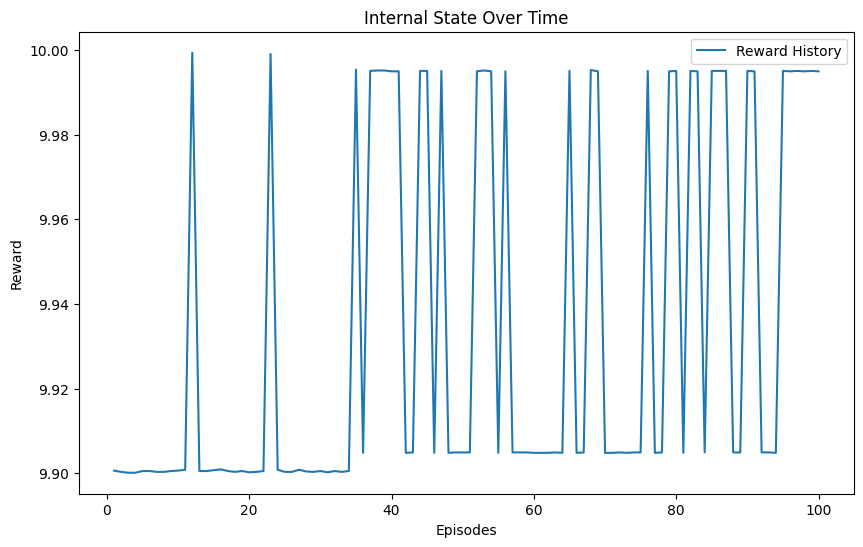

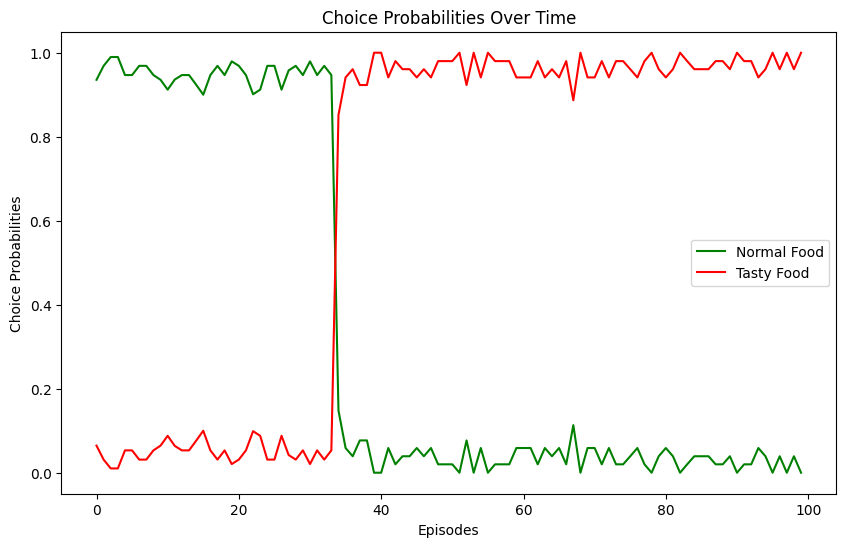

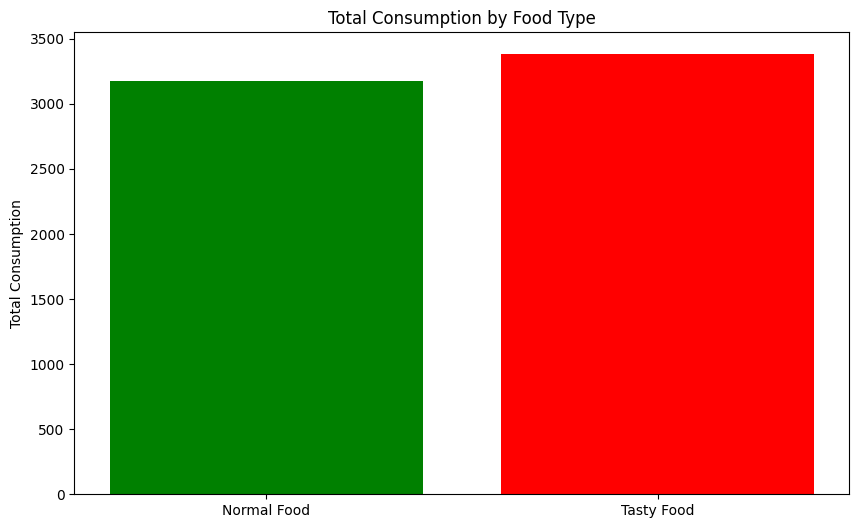

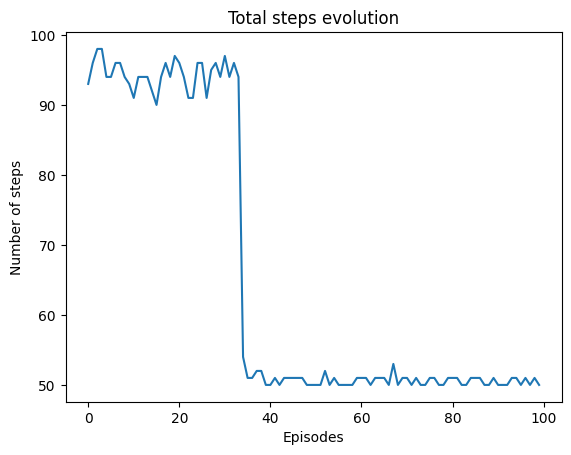

In [529]:
# Génération des graphiques
time = np.arange(1, len(reward_history) + 1)

# État interne au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(time, reward_history, label="Reward History")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Internal State Over Time")
plt.legend()
plt.show()

# Probabilités de choix
plt.figure(figsize=(10, 6))
plt.plot(choice_probabilities[0], label="Normal Food", color="green")
plt.plot(choice_probabilities[1], label="Tasty Food", color="red")
plt.xlabel("Episodes")
plt.ylabel("Choice Probabilities")
plt.title("Choice Probabilities Over Time")
plt.legend()
plt.show()

# Consommation totale
total_consumption_normal = sum([episode.count(0) for episode in choices_history])
total_consumption_tasty = sum([episode.count(1) for episode in choices_history])

plt.figure(figsize=(10, 6))
plt.bar(["Normal Food", "Tasty Food"], [total_consumption_normal, total_consumption_tasty], color=["green", "red"])
plt.ylabel("Total Consumption")
plt.title("Total Consumption by Food Type")
plt.show()

# Total steps evolution over episodes 
plt.plot(range(0,episodes),total_steps_history)
plt.xlabel("Episodes")
plt.ylabel("Number of steps")
plt.title("Total steps evolution")
plt.show()